In [ ]:
# Restart with command below if keras uses Theano backend
# KERAS_BACKEND=tensorflow jupyter notebook --no-browser

In [ ]:
# Use command below in terminal to view the network's TensorBoard
# tensorboard --logdir=./logs

# Then go to EC2 Instance's public DNS port 6006

## Network "works" but is not accurate (not better than random)  
### Things to try:  
* use TensorBoard
* play around with hyperparameters  
* play around with layers  
* play arond with hidden layer activations
* frame augmentation  
* manually adjust videos where subject is not centered  
* get more data (videos) - only have 120

In [1]:
import numpy as np
from time import sleep
import sys

import tensorflow as tf
import keras
from keras.applications import InceptionV3
from keras.models import Model
from keras.layers import Input, Dense, Activation, TimeDistributed, LSTM, Dropout, Lambda
from keras.preprocessing import image
from keras.callbacks import TensorBoard

from sklearn.preprocessing import LabelEncoder
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

%matplotlib inline
import matplotlib.pyplot as plt
import pylab
from PIL import Image
import imageio
#imageio.plugins.ffmpeg.download()

import scipy
import os

Using TensorFlow backend.
/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [23]:
VIDEO_FOLDER = (os.getcwd() + '/videos/Clips')
EPOCHS = 3
BATCH_SIZE = 3
FRAME_SQUARE_DIM = 178
FRAMES_PER_VIDEO = 30
DROP_PROB = 0.3
LSTM_UNITS = 1024
FIRST_DENSE_UNITS = 512
SECOND_DENSE_UNITS = 512
TEST_SIZE = 0.1

In [7]:
keras.backend.clear_session()

In [8]:
tensorboard = TensorBoard(log_dir='./logs')

In [9]:
keras.backend.set_learning_phase(0)

In [10]:
def get_model(frames_per_video, frame_square_dim, drop_prob, lstm_units, first_dense_units, second_dense_units):
    # Video file placeholder. Shape = (# of frames, frame-width, frame-length, # of frame-channels (i.e. rgb))
    video_input = Input(shape=(frames_per_video, frame_square_dim, frame_square_dim, 3), name='video_input')

    # TRANSFER LEARNING LAYER
    # Initialize CNN with weights from InceptionV3 trained on Imagenet.
    IncV3 = InceptionV3(weights='imagenet', include_top=False, pooling='avg')

    # Freeze Inception layers, so we can use the already trained weights that represent lower level
    # vision and pattern recognition.
    IncV3.trainable = False
    
    # TIME DISTRIBUTION LAYER
    # Run each frame through an InceptionV3 CNN layer.
    encoded_frames = TimeDistributed(Lambda(lambda x: IncV3(x)), name='encoded_frames')(video_input)

    # LSTM LAYER
    # Run each frames CNN output through the LSTM layer.
    encoded_vid = LSTM(units=lstm_units, dropout=drop_prob, name='encoded_vid')(encoded_frames)

    # ADDITIONAL LAYERS TO TRAIN NEW CLASSES from our new video footage.
    # Add fully-connected layers before predictions.
    first_dense = Dense(units=first_dense_units, activation='relu', name='first_dense')(encoded_vid)
    second_dense = Dense(units=second_dense_units, activation='relu', name='second_dense')(first_dense)

    # Add a logistic layer with 2 new classes - "Lying" and "Truth".
    predictions = Dense(1, activation='sigmoid', name='predictions')(second_dense)

    # Throw it all into a Model object.
    model = Model(inputs=[video_input], outputs=predictions)

    # Compile the model.
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [11]:
model = get_model(FRAMES_PER_VIDEO, FRAME_SQUARE_DIM, DROP_PROB, LSTM_UNITS, FIRST_DENSE_UNITS, SECOND_DENSE_UNITS)
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
video_input (InputLayer)     (None, 30, 178, 178, 3)   0         
_________________________________________________________________
encoded_frames (TimeDistribu (None, 30, 2048)          0         
_________________________________________________________________
encoded_vid (LSTM)           (None, 1024)              12587008  
_________________________________________________________________
first_dense (Dense)          (None, 512)               524800    
_________________________________________________________________
second_dense (Dense)         (None, 512)               262656    
_________________________________________________________________
predictions (Dense)          (None, 1)                 513       
Total params: 13,374,977.0
Trainable params: 13,374,977.0
Non-trainable params: 0.0
__________________________________________________________

In [12]:
# Make Frames directories in Truthful and Deceptive folders
if not os.path.exists((VIDEO_FOLDER + '/Truthful/Frames')):
    os.mkdir(VIDEO_FOLDER + '/Truthful/Frames')
if not os.path.exists((VIDEO_FOLDER + '/Deceptive/Frames')):
    os.mkdir(VIDEO_FOLDER + '/Deceptive/Frames')

In [13]:
def resize_and_crop(frame, square_dim):
    # get aspect ratio
    aspect = frame.size[0]/frame.size[1]
    
    # resize to 178 on shortest side and keep original aspect ratio
    frame = frame.resize((int(square_dim*aspect), square_dim))
    
    # crop 178 square from center
    half_the_width = frame.size[0] / 2
    half_the_height = frame.size[1] / 2
    frame = frame.crop(
        (
            half_the_width - (square_dim/2),
            half_the_height - (square_dim/2),
            half_the_width + (square_dim/2),
            half_the_height + (square_dim/2)
        )
    )
    
    return frame

In [14]:
def get_frames_from_videos(folder, frames_per_video, frame_square_dim):
    
    # Throw out any old frames.
    for existing_frame in os.listdir((folder + '/Frames/')):
        os.remove((folder + '/Frames/' + existing_frame))
    
    # get one video at a time in the folder
    print("Down sampling video frames.")
    vid_counter = 0
    for video_file in os.listdir(folder):
        vid_counter += 1
        
        if video_file not in ['Frames']:
            # printing status
            sys.stdout.write('\r')
            sys.stdout.flush()
            sys.stdout.write('Getting frames for video ' + str(vid_counter) + ' of ' + str(len(os.listdir(folder))))
            sys.stdout.flush()
            
            video = (folder + '/' + video_file)
            video = imageio.get_reader(video,  'ffmpeg')

            # get 30 evenly spaced frames per video
            step = video.get_meta_data()['nframes'] / frames_per_video
            frames_to_get = range(1, video.get_meta_data()['nframes'], int(step))
            frames = []
            for i in frames_to_get:
                frames.append(i)

            # only get number of frames equal to FRAMES_PER_VIDEO if there are more
            frames = frames[:frames_per_video]

            # Resize, crop, and save each frame in the Frames folder
            ## ex: (os.getcwd + '/videos/Clips/Truthful/Frames') for Truth videos
            for frame in frames:
                this_frame = video.get_data(frame)
                imageio.imwrite("this_frame.jpg", this_frame)
                this_frame = Image.open("this_frame.jpg")
                this_frame = resize_and_crop(this_frame, frame_square_dim)
                this_frame.save((folder + '/Frames/' + video_file + '_0' + str(frame) + '.jpg'))
                
    print('\n')
    print('Complete!')

In [15]:
def get_data(folder, frames_per_video):
    X = []
    y = []

    for vid_type in os.listdir(folder):
        if not vid_type.startswith('.'):
            if vid_type in ['Deceptive']:
                label = 'Deceptive'
            else:
                label = 'Truthful'
            
            video_tensor = []
            frame_counter = 1
            frame_files = os.listdir(folder + '/' + vid_type + '/Frames')
            for frame_file_iter in range(len(frame_files)):
                if frame_file_iter == 0:
                    continue
                
                frame = (folder + '/' + vid_type + '/Frames/' + frame_files[frame_file_iter])

                frame = Image.open(frame)

                frame_tensor = np.asarray(frame.convert('RGB'))
                
                video_tensor.append(frame_tensor)
                
                if frame_counter == frames_per_video:
                    X.append(video_tensor)
                    y.append(label)
                    
                    video_tensor = []
                    frame_counter = 0
                    
                frame_counter += 1
                
    X = np.asarray(X)
    y = np.asarray(y)
    print('Complete!')
    return X,y

In [16]:
# Prepare video clips into a resized and cropped series of frames for each video
get_frames_from_videos((VIDEO_FOLDER + '/Deceptive'), FRAMES_PER_VIDEO, FRAME_SQUARE_DIM)

Down sampling video frames.
Getting frames for video 62 of 62

Complete!


In [17]:
# Prepare video clips into a resized and cropped series of frames for each video
get_frames_from_videos((VIDEO_FOLDER + '/Truthful'), FRAMES_PER_VIDEO, FRAME_SQUARE_DIM)

Down sampling video frames.
Getting frames for video 61 of 61

Complete!


In [24]:
# Get video tensors ready for network input
X, y = get_data(VIDEO_FOLDER, FRAMES_PER_VIDEO)

Complete!


In [25]:
X.shape

(119, 30, 178, 178, 3)

In [26]:
# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=42)
print('Complete!')

Complete!


In [27]:
# Encode target labels
encoder = LabelEncoder()
encoder.fit(y_train)
y_train = encoder.transform(y_train)
y_test = encoder.transform(y_test)
print('Complete!')

Complete!


In [28]:
# Train the model on the new video footage.

# fits the model on batches
history = model.fit(
    X_train,
    y_train,
    validation_split=TEST_SIZE,
    epochs=EPOCHS,
    shuffle=True,
    batch_size=BATCH_SIZE,
    callbacks=[tensorboard])

#model.save_weights('model.h5')

Train on 96 samples, validate on 11 samples
Epoch 1/3
96/96 [==============================] - 233s - loss: 0.9525 - acc: 0.4688 - val_loss: 0.7183 - val_acc: 0.2727

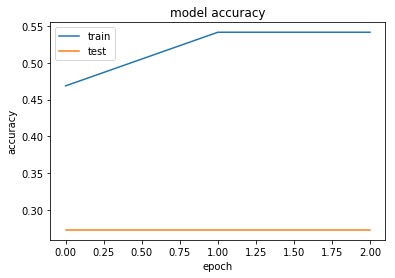

In [29]:
def plot_learning_curve(history):
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./accuracy_curve.png')
    plt.show()

plot_learning_curve(history)

In [30]:
# Test on the out of sample (test) video footage.
X_test = X_test.astype('float32')

print('Predicting on test data')
y_pred = np.rint(model.predict(X_test))

print(accuracy_score(y_test, y_pred))

Predicting on test data
0.5


In [31]:
# Show confusion matrix
print(confusion_matrix(y_test, y_pred))

[[6 0]
 [6 0]]


In [32]:
for test,pred in zip(y_test, y_pred):
    print(str(test) + ' : ' + str(pred[0]))

0 : 0.0
1 : 0.0
0 : 0.0
0 : 0.0
0 : 0.0
1 : 0.0
1 : 0.0
0 : 0.0
1 : 0.0
1 : 0.0
0 : 0.0
1 : 0.0
